In [1]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!ls

!pwd

cancer.ipynb  health.ipynb  slide_1.png
/mnt/ufs18/home-144/dingjia5/projects/CosMx_liver/benchmark_generation_scripts


In [ ]:
"""
GeoMx: spot region area
1. mean: 37456.28 μm2
2. median: 24168.74 μm2
"""

In [ ]:
"""
CosMx lung, kidney: 
1. All FOVs are the same dimension, 5472 x 3648 pixels
2. multiply the pixel value by 0.18 um per pixel
3. FOV area: 5472 x 3648 pixels -> 984.96um x 656.64um = 646,764.134 um2 

New Benchamrk from CosMx
1. length: 5472 pixels, width: 3648 pixels
2. simulated spot: 
    length: 5472 pixels / 5 = 1094.4 pixel = 196.992 um
    width: 3648 pixels / 4 = 912 pixel = 164.16 um
    one spot area: 196.992 um * 164.16 um = 32338.2067 um2
3. In total: 20 spots / FOV

"""

In [4]:
"""
CosMx liver:
1. All FOVs are the same dimension: 4236 * 4236 pixels, 0.12um per pixel
2. simulated spot: 
        4236 / 3.0 = 1412 pixels = 169.44 um
        169.44 um * 169.44 um = 28709.9136 um2
"""

'\nCosMx liver:\n1. All FOVs are the same dimension: 4236 * 4236 pixels, 0.12um per pixel\n2. simulated spot: \n        4236 / 3.0 = 1412 pixels = 169.44 um\n        169.44 um * 169.44 um = 28709.9136 um2\n'

# Transcript Data

In [4]:

import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd

from torch.utils.data import DataLoader, Dataset, TensorDataset

import time
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd
from collections import Counter

In [5]:
CosMx_cell_type = pd.read_csv('../liver_cellType.csv')
CosMx_cell_type

Unnamed: 0       cell_ID                      cellType
0         c_1_100_10    c_1_100_10                         Hep.3
1       c_1_100_1078  c_1_100_1078                         Hep.4
2       c_1_100_1135  c_1_100_1135      Inflammatory.macrophages
3        c_1_100_267   c_1_100_267                         Hep.5
4        c_1_100_732   c_1_100_732          Central.venous.LSECs
...              ...           ...                           ...
793313     c_2_9_945     c_2_9_945      Inflammatory.macrophages
793314     c_2_9_947     c_2_9_947  Non.inflammatory.macrophages
793315     c_2_9_948     c_2_9_948                       tumor_1
793316     c_2_9_949     c_2_9_949                       tumor_1
793317      c_2_9_95      c_2_9_95                       tumor_1

[793318 rows x 3 columns]

In [6]:
sample_cell_count_dic = {}
sample_fov_count_dic = {}
for i in range(1, 11):
    sample_cell_count_dic[i] = 0
    sample_fov_count_dic[i] = []
print("cell:", sample_cell_count_dic)
print("fov:", sample_fov_count_dic)

cell: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
fov: {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: []}


In [7]:
sample_1_index_lst = []

cell_id_lst = CosMx_cell_type["cell_ID"].tolist()
print("len of cell_id_lst:", len(cell_id_lst))

fov_lst = []

index = 0
for i in range(len(cell_id_lst)):
    sample_id = int(cell_id_lst[i].split("_")[1])
    fov_id = int(cell_id_lst[i].split("_")[2])
    cell_id = int(cell_id_lst[i].split("_")[3])

    if sample_id == 5:
        sample_1_index_lst.append(index)
        
    sample_cell_count_dic[sample_id] =  sample_cell_count_dic[sample_id] + 1
    
    if fov_id not in sample_fov_count_dic[sample_id]:
        sample_fov_count_dic[sample_id].append(fov_id)
    
    if sample_id == 5:
        if fov_id not in fov_lst:
            fov_lst.append(fov_id)
    index += 1

len of cell_id_lst: 793318


In [8]:
print(sample_cell_count_dic)
print(sample_fov_count_dic)
print(fov_lst)
print(len(sample_1_index_lst))

{1: 332877, 2: 460441, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
{1: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 10, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 11, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 12, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 13, 140, 141, 142, 143, 144, 145, 146, 147, 149, 14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 15, 160, 161, 162, 163, 164, 165, 166, 167, 169, 16, 170, 171, 172, 173, 174, 176, 177, 178, 179, 17, 182, 184, 185, 186, 187, 188, 189, 18, 190, 191, 192, 193, 194, 195, 197, 198, 199, 19, 1, 200, 201, 202, 203, 204, 205, 207, 208, 209, 20, 210, 211, 212, 214, 215, 216, 217, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 22, 230, 231, 234, 235, 236, 237, 238, 239, 23, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 24, 250, 251, 253, 254, 255, 256, 257, 258, 259, 25, 260, 261, 262, 263, 264, 265, 266, 269, 26, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 27, 280, 281, 282, 284, 286, 288, 28

In [9]:
len(sample_fov_count_dic[1]), len(sample_fov_count_dic[2])

(301, 383)

In [10]:
sample_1_rows = CosMx_cell_type["Unnamed: 0"].str.startswith("c_1_")
sample_1 = CosMx_cell_type.loc[sample_1_rows, :]
sample_1

Unnamed: 0       cell_ID                  cellType
0         c_1_100_10    c_1_100_10                     Hep.3
1       c_1_100_1078  c_1_100_1078                     Hep.4
2       c_1_100_1135  c_1_100_1135  Inflammatory.macrophages
3        c_1_100_267   c_1_100_267                     Hep.5
4        c_1_100_732   c_1_100_732      Central.venous.LSECs
...              ...           ...                       ...
566002     c_1_9_981     c_1_9_981                     Hep.4
566003     c_1_9_982     c_1_9_982     gamma.delta.T.cells.1
566004     c_1_9_985     c_1_9_985                     Hep.4
566005     c_1_9_987     c_1_9_987             NK.like.cells
566006     c_1_9_995     c_1_9_995                     Hep.5

[332877 rows x 3 columns]

In [11]:
set(sample_1["cellType"].values.tolist())
sample_1_dic = {}
for index, row in sample_1.iterrows():
    if row["cellType"] in sample_1_dic:
        sample_1_dic[row["cellType"]] += 1
    else:
        sample_1_dic[row["cellType"]] = 1
        
sample_1_dic

{'Hep.3': 21274,
 'Hep.4': 125997,
 'Inflammatory.macrophages': 5882,
 'Hep.5': 89334,
 'Central.venous.LSECs': 4416,
 'CD3+.alpha.beta.T.cells': 13664,
 'NK.like.cells': 2752,
 'gamma.delta.T.cells.1': 3181,
 'Stellate.cells': 16482,
 'Non.inflammatory.macrophages': 9556,
 'Hep.1': 17364,
 'Erthyroid.cells': 1044,
 'Mature.B.cells': 2928,
 'Portal.endothelial.cells': 537,
 'Periportal.LSECs': 6083,
 'Cholangiocytes': 4783,
 'Hep.6': 6183,
 'Antibody.secreting.B.cells': 1413,
 'NotDet': 4}

In [12]:
cell_boundary = pd.read_csv('../liver_cell_positions_file.csv')
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov  
0          9.73500  100  
1          9.25824  100  
2          9.23412  100  
3          9.61104  100  
4          9.40548  100  
...            ...  ...  
793313    11.27840    9  
793314    11.27804    9  
793315    11.27792    9  
793316    11.27732    9  
793317    11.70812    9  

[793318 rows x 7 columns]

In [13]:
cell_boundary['cell_single_id'] = cell_boundary['cell_ID'].apply(lambda x: x.split('_')[-1])

In [14]:
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
793313    11.27840    9            945  
793314    11.27804    9            947  
793315    11.27792    9            948  
793316    11.27732    9            949  
793317    11.70812    9             95  

[793318 rows x 8 columns]

In [15]:
sample_1_rows = cell_boundary["cell_ID"].str.startswith("c_1_")
cell_boundary_health = cell_boundary.loc[sample_1_rows, :]
cell_boundary_health

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
566002     c_1_9_981     c_1_9_981      2426      3499     5.41012   
566003     c_1_9_982     c_1_9_982       305      3474     5.15560   
566004     c_1_9_985     c_1_9_985       706      3504     5.20372   
566005     c_1_9_987     c_1_9_987      1623      3517     5.31376   
566006     c_1_9_995     c_1_9_995      3808      3594     5.57596   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
566002    11.36612    9            981  
566003    11.36912    9            982  
566004    11.36552    9            985  
566005    11.36396    9            987  
566006    11.35472    9            995  

[332877 rows x 8 columns]

In [16]:
mapping = {"Sample_1": [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], "Sample_2": [11, 12, 13, 14, 26, 27, 28, 29, 30, 42, 43, 44, 45, 46, 60, 61, 62, 63, 64, 65, 79, 80, 81, 82, 83, 84, 85, 99, 100, 101, 102, 103, 104, 105, 106, 119, 120, 121, 122, 123, 124, 125, 126, 140, 141, 142, 143, 144, 145, 146, 147, 148, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194], "Sample_3": [195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 262, 263, 264, 265, 266, 267, 268, 269, 281, 282, 283, 284, 285, 286, 287, 299, 300, 301, 302, 303, 304, 305, 316, 317, 318, 319, 320, 321, 322, 333, 334, 335, 336, 337, 346], "Sample_4": [207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 323, 324, 325, 326, 327, 328, 329, 330, 331, 338, 339, 340, 341, 342, 343, 344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 364, 365, 366, 367, 368, 372, 373, 374, 375, 377, 378, 379]}

In [17]:
filtered_fov_lst = mapping["Sample_1"] + mapping["Sample_2"] + mapping["Sample_3"] + mapping["Sample_4"]
filtered_fov_lst

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 11,
 12,
 13,
 14,
 26,
 27,
 28,
 29,
 30,
 42,
 43,
 44,
 45,
 46,
 60,
 61,
 62,
 63,
 64,
 65,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203

In [18]:
len(filtered_fov_lst)

353

In [19]:
cell_boundary_health[cell_boundary_health['fov'].isin(filtered_fov_lst)]

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
566002     c_1_9_981     c_1_9_981      2426      3499     5.41012   
566003     c_1_9_982     c_1_9_982       305      3474     5.15560   
566004     c_1_9_985     c_1_9_985       706      3504     5.20372   
566005     c_1_9_987     c_1_9_987      1623      3517     5.31376   
566006     c_1_9_995     c_1_9_995      3808      3594     5.57596   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
566002    11.36612    9            981  
566003    11.36912    9            982  
566004    11.36552    9            985  
566005    11.36396    9            987  
566006    11.35472    9            995  

[312691 rows x 8 columns]

In [20]:
cell_boundary_health

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
566002     c_1_9_981     c_1_9_981      2426      3499     5.41012   
566003     c_1_9_982     c_1_9_982       305      3474     5.15560   
566004     c_1_9_985     c_1_9_985       706      3504     5.20372   
566005     c_1_9_987     c_1_9_987      1623      3517     5.31376   
566006     c_1_9_995     c_1_9_995      3808      3594     5.57596   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
566002    11.36612    9            981  
566003    11.36912    9            982  
566004    11.36552    9            985  
566005    11.36396    9            987  
566006    11.35472    9            995  

[332877 rows x 8 columns]

In [21]:
fov_ids_lst_health = cell_boundary_health['fov'].unique()
fov_ids_lst_health

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146, 147,
       149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,  15,
       160, 161, 162, 163, 164, 165, 166, 167, 169,  16, 170, 171, 172,
       173, 174, 176, 177, 178, 179,  17, 182, 184, 185, 186, 187, 188,
       189,  18, 190, 191, 192, 193, 194, 195, 197, 198, 199,  19,   1,
       200, 201, 202, 203, 204, 205, 207, 208, 209,  20, 210, 211, 212,
       214, 215, 216, 217, 219, 220, 221, 223, 224, 225, 226, 227, 228,
       229,  22, 230, 231, 234, 235, 236, 237, 238, 239,  23, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249,  24, 250, 251, 253, 254,
       255, 256, 257, 258, 259,  25, 260, 261, 262, 263, 264, 265, 266,
       269,  26, 270, 271, 272, 273, 274, 275, 276, 277, 278, 27

In [22]:
for fov_id in fov_ids_lst_health:
    print("fov_id:", fov_id, cell_boundary_health[(cell_boundary_health['fov']==fov_id)].shape)
    fov_whole = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]
#     print(fov_whole)
#     print(fov_whole["x_FOV_px"].max() - fov_whole["x_FOV_px"].min(), fov_whole["y_FOV_px"].max() - fov_whole["y_FOV_px"].min())
    print(fov_whole["x_FOV_px"].max(), fov_whole["x_FOV_px"].min())
    print(fov_whole["y_FOV_px"].max(), fov_whole["y_FOV_px"].min())
    

fov_id: 100 (1239, 8)
4245 12
4236 24
fov_id: 101 (1224, 8)
4243 16
4242 18
fov_id: 102 (1196, 8)
4237 19
4237 17
fov_id: 103 (1140, 8)
4240 26
4237 20
fov_id: 104 (1271, 8)
4234 18
4241 15
fov_id: 105 (131, 8)
2167 16
4235 65
fov_id: 106 (259, 8)
4240 898
4232 28
fov_id: 107 (1187, 8)
4241 14
4236 16
fov_id: 108 (1138, 8)
4230 16
4241 14
fov_id: 109 (1353, 8)
4237 20
4233 19
fov_id: 10 (1388, 8)
4241 19
4242 18
fov_id: 110 (1243, 8)
4237 16
4239 20
fov_id: 111 (1379, 8)
4244 20
4238 16
fov_id: 112 (1365, 8)
4234 21
4235 16
fov_id: 113 (1152, 8)
4241 15
4241 17
fov_id: 114 (1184, 8)
4245 16
4240 17
fov_id: 115 (1111, 8)
4243 19
4244 17
fov_id: 116 (622, 8)
4234 15
2977 19
fov_id: 117 (802, 8)
4239 14
4107 21
fov_id: 118 (1357, 8)
4240 22
4242 17
fov_id: 119 (1289, 8)
4237 19
4240 19
fov_id: 11 (1250, 8)
4238 18
4242 14
fov_id: 120 (1230, 8)
4236 13
4238 16
fov_id: 121 (1269, 8)
4235 20
4239 14
fov_id: 122 (1162, 8)
4233 16
4235 13
fov_id: 123 (1132, 8)
4242 20
4239 18
fov_id: 124 (1358

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

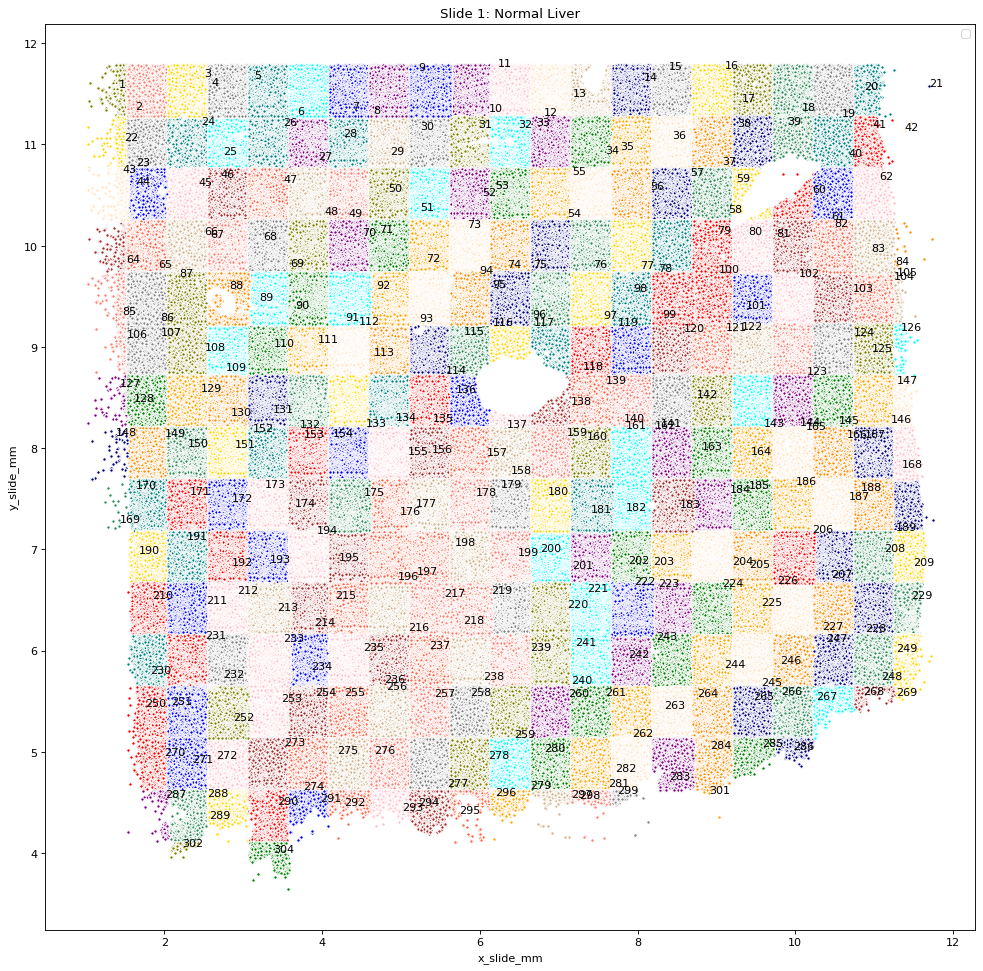

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"] * 25
recorded_fov = []
for i in range(len(fov_ids_lst_health)):
    fov_id = fov_ids_lst_health[i]
    X = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["x_slide_mm"].tolist()
    Y = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["y_slide_mm"].tolist()
    
#     plt.scatter(X, Y, s=100, label = fov_id,  c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.scatter(X, Y, s=40, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()
    
    if fov_id not in recorded_fov:
        plt.annotate(str(fov_id), (X[0], Y[0]))

plt.title('Slide 1: Normal Liver')
plt.xlabel('x_slide_mm')  
plt.ylabel('y_slide_mm')  
plt.savefig('slide_1.png') 
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

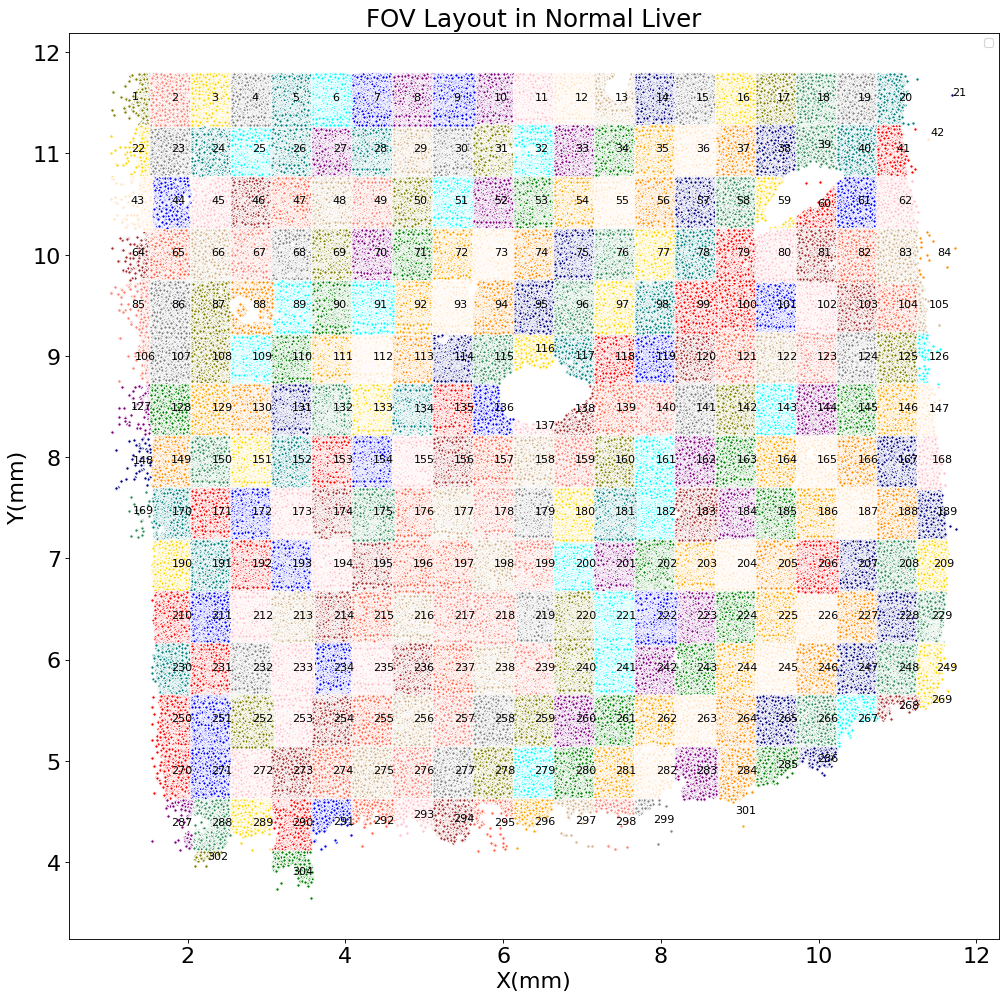

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15), dpi=80)

np.random.seed(20)
color = ["red", "blue", "pink", "brown", "tomato", "tan", "salmon", "gray", "olive", "cyan", "purple", "green", "orange", "bisque", "darkorange", "navy", "seagreen", "gold", "teal"] * 25
recorded_fov = []
for i in range(len(fov_ids_lst_health)):
    fov_id = fov_ids_lst_health[i]
    X = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["x_slide_mm"].tolist()
    Y = cell_boundary_health[(cell_boundary_health['fov']==fov_id)]["y_slide_mm"].tolist()
#     import ipdb
#     ipdb.set_trace()

#     plt.scatter(X, Y, s=100, label = fov_id,  c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.scatter(X, Y, s=40, c = color[i], marker='.', alpha = None, edgecolors= 'white')
    plt.legend()
    
    if fov_id not in recorded_fov:
#         plt.annotate(str(fov_id), (X[50], Y[50]), size=20)
        plt.annotate(str(fov_id), ((max(X) - min(X))/2.0 + min(X), (max(Y) - min(Y))/2.0 + min(Y)), size=10)
#     if i > 10:
#         break

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('FOV Layout in Normal Liver',fontsize=22)
plt.xlabel('X(mm)', fontsize=20)  
plt.ylabel('Y(mm)', fontsize=20)  
plt.savefig("../../FOV_layout/normal_liver.png", format="png", bbox_inches="tight")
plt.show()


# Benchmark Generation

## 1. spot_fov_cellId_mapping.csv

In [19]:
def get_spot_fov_cellId_mapping(data_result, cell_boundary_fov_11):
    x_min = cell_boundary_fov_11["x_FOV_px"].min()
    x_max = cell_boundary_fov_11["x_FOV_px"].max()
    y_min = cell_boundary_fov_11["y_FOV_px"].min()
    y_max = cell_boundary_fov_11["y_FOV_px"].max()
    
#     print("x:", x_min, x_max)
#     print("y:", y_min, y_max)
    # x: 12 4245
    # y: 24 4236
#     import ipdb
#     ipdb.set_trace()
    x_diff = (x_max - x_min) / 3.0
    y_diff = (y_max - y_min) / 3.0
    
    new_col_val = cell_boundary_fov_11.shape[0]* [0]
    cell_boundary_fov_11.insert(loc=0, column='spot_id', value=new_col_val)

    for i in range(cell_boundary_fov_11.shape[0]):
        one_row_sample = cell_boundary_fov_11.iloc[i]
        if one_row_sample["x_FOV_px"] <= x_min + x_diff * 1:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 1
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 2
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 3
    

        elif one_row_sample["x_FOV_px"] <=  x_min + x_diff * 2:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 4
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 5
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 6
     

        elif one_row_sample["x_FOV_px"] <= x_min + x_diff * 3:
            if one_row_sample["y_FOV_px"] <= y_min + y_diff * 1:
                spot_id = 7
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 2:
                spot_id = 8
            elif one_row_sample["y_FOV_px"] <= y_min + y_diff * 3:
                spot_id = 9

        else:
            print("Wrong x_FOV_px, y_FOV_px:", one_row_sample["x_FOV_px"], one_row_sample["y_FOV_px"])
        data_result = data_result.append({'spot_id' : spot_id, 'fov' : one_row_sample["fov"], 'cell_ID' : one_row_sample["cell_single_id"]}, ignore_index = True)

    return data_result

        

In [20]:
data_final_result = pd.DataFrame(columns = [ 'fov', 'spot_id', 'cell_ID'])
data_final_result

Empty DataFrame
Columns: [fov, spot_id, cell_ID]
Index: []

In [21]:
cell_boundary_health

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
566002     c_1_9_981     c_1_9_981      2426      3499     5.41012   
566003     c_1_9_982     c_1_9_982       305      3474     5.15560   
566004     c_1_9_985     c_1_9_985       706      3504     5.20372   
566005     c_1_9_987     c_1_9_987      1623      3517     5.31376   
566006     c_1_9_995     c_1_9_995      3808      3594     5.57596   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
566002    11.36612    9            981  
566003    11.36912    9            982  
566004    11.36552    9            985  
566005    11.36396    9            987  
566006    11.35472    9            995  

[332877 rows x 8 columns]

In [22]:
type(cell_boundary_health)

pandas.core.frame.DataFrame

In [23]:
fov_ids_lst = cell_boundary_health['fov'].unique()
fov_ids_lst

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109,  10, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119,  11, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129,  12, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139,  13, 140, 141, 142, 143, 144, 145, 146, 147,
       149,  14, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,  15,
       160, 161, 162, 163, 164, 165, 166, 167, 169,  16, 170, 171, 172,
       173, 174, 176, 177, 178, 179,  17, 182, 184, 185, 186, 187, 188,
       189,  18, 190, 191, 192, 193, 194, 195, 197, 198, 199,  19,   1,
       200, 201, 202, 203, 204, 205, 207, 208, 209,  20, 210, 211, 212,
       214, 215, 216, 217, 219, 220, 221, 223, 224, 225, 226, 227, 228,
       229,  22, 230, 231, 234, 235, 236, 237, 238, 239,  23, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249,  24, 250, 251, 253, 254,
       255, 256, 257, 258, 259,  25, 260, 261, 262, 263, 264, 265, 266,
       269,  26, 270, 271, 272, 273, 274, 275, 276, 277, 278, 27

In [116]:
fov_ids_lst = cell_boundary_health['fov'].unique()
print("fov_ids_lst:", fov_ids_lst)

for fov_id in fov_ids_lst:
    print("fov_id:", fov_id)
    cell_boundary_health_fov =  cell_boundary_health[(cell_boundary_health['fov']==fov_id)]
    print("cell_boundary_health_fov_without_spot_id:", cell_boundary_health_fov.shape)
    data_final_result = get_spot_fov_cellId_mapping(data_final_result, cell_boundary_health_fov)
#     print(data_final_result)
#     break

data_final_result

fov_ids_lst: [100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117 118 119  11 120 121 122 123 124 125 126 127 128 129  12 130 131 132
 133 134 135 136 137 138 139  13 140 141 142 143 144 145 146 147 149  14
 150 151 152 153 154 155 156 157 158 159  15 160 161 162 163 164 165 166
 167 169  16 170 171 172 173 174 176 177 178 179  17 182 184 185 186 187
 188 189  18 190 191 192 193 194 195 197 198 199  19   1 200 201 202 203
 204 205 207 208 209  20 210 211 212 214 215 216 217 219 220 221 223 224
 225 226 227 228 229  22 230 231 234 235 236 237 238 239  23 240 241 242
 243 244 245 246 247 248 249  24 250 251 253 254 255 256 257 258 259  25
 260 261 262 263 264 265 266 269  26 270 271 272 273 274 275 276 277 278
 279  27 280 281 282 284 286 288 289  28 290 291 293 294 295  29   2  30
  31  32  33  34  35  36  37  38  39   3  40  41  44  45  46  47  48  49
   4  50  51  52  53  54  55  56  57  58  59   5  60  61  62  64  65  66
  67  68  69   6  70  71  72  73  74  

fov_id: 207
cell_boundary_health_fov_without_spot_id: (1280, 8)
fov_id: 208
cell_boundary_health_fov_without_spot_id: (1274, 8)
fov_id: 209
cell_boundary_health_fov_without_spot_id: (977, 8)
fov_id: 20
cell_boundary_health_fov_without_spot_id: (869, 8)
fov_id: 210
cell_boundary_health_fov_without_spot_id: (1048, 8)
fov_id: 211
cell_boundary_health_fov_without_spot_id: (1123, 8)
fov_id: 212
cell_boundary_health_fov_without_spot_id: (1271, 8)
fov_id: 214
cell_boundary_health_fov_without_spot_id: (1257, 8)
fov_id: 215
cell_boundary_health_fov_without_spot_id: (1326, 8)
fov_id: 216
cell_boundary_health_fov_without_spot_id: (1294, 8)
fov_id: 217
cell_boundary_health_fov_without_spot_id: (1216, 8)
fov_id: 219
cell_boundary_health_fov_without_spot_id: (1233, 8)
fov_id: 220
cell_boundary_health_fov_without_spot_id: (1187, 8)
fov_id: 221
cell_boundary_health_fov_without_spot_id: (1273, 8)
fov_id: 223
cell_boundary_health_fov_without_spot_id: (1125, 8)
fov_id: 224
cell_boundary_health_fov_withou

fov_id: 72
cell_boundary_health_fov_without_spot_id: (1176, 8)
fov_id: 73
cell_boundary_health_fov_without_spot_id: (1167, 8)
fov_id: 74
cell_boundary_health_fov_without_spot_id: (1326, 8)
fov_id: 75
cell_boundary_health_fov_without_spot_id: (1284, 8)
fov_id: 76
cell_boundary_health_fov_without_spot_id: (1267, 8)
fov_id: 77
cell_boundary_health_fov_without_spot_id: (1332, 8)
fov_id: 78
cell_boundary_health_fov_without_spot_id: (1433, 8)
fov_id: 79
cell_boundary_health_fov_without_spot_id: (1256, 8)
fov_id: 7
cell_boundary_health_fov_without_spot_id: (1323, 8)
fov_id: 80
cell_boundary_health_fov_without_spot_id: (1099, 8)
fov_id: 81
cell_boundary_health_fov_without_spot_id: (1219, 8)
fov_id: 82
cell_boundary_health_fov_without_spot_id: (1247, 8)
fov_id: 83
cell_boundary_health_fov_without_spot_id: (1173, 8)
fov_id: 85
cell_boundary_health_fov_without_spot_id: (410, 8)
fov_id: 86
cell_boundary_health_fov_without_spot_id: (1247, 8)
fov_id: 87
cell_boundary_health_fov_without_spot_id: (124

fov spot_id cell_ID
0       100       4      10
1       100       3    1078
2       100       6    1135
3       100       7     267
4       100       8     732
...     ...     ...     ...
332872   84       2      62
332873   84       3      73
332874   84       3      74
332875   84       3      77
332876   21       1       7

[332877 rows x 3 columns]

In [117]:
data_final_result

fov spot_id cell_ID
0       100       4      10
1       100       3    1078
2       100       6    1135
3       100       7     267
4       100       8     732
...     ...     ...     ...
332872   84       2      62
332873   84       3      73
332874   84       3      74
332875   84       3      77
332876   21       1       7

[332877 rows x 3 columns]

In [118]:
data_final_result_sample = data_final_result[(data_final_result['fov']==8)]
data_final_result_sample

fov spot_id cell_ID
296927   8       3    1147
296928   8       2     474
296929   8       8     482
296930   8       2     518
296931   8       3     880
...     ..     ...     ...
298230   8       4      99
298231   8       9     991
298232   8       9     992
298233   8       6     994
298234   8       3     998

[1308 rows x 3 columns]

In [119]:
data_final_result.to_csv('../health/new/spot_fov_cellId_mapping.csv')

In [120]:
data_final_result

fov spot_id cell_ID
0       100       4      10
1       100       3    1078
2       100       6    1135
3       100       7     267
4       100       8     732
...     ...     ...     ...
332872   84       2      62
332873   84       3      73
332874   84       3      74
332875   84       3      77
332876   21       1       7

[332877 rows x 3 columns]

## 2. spot_gene_expression.csv

In [17]:
cell_boundary

Unnamed: 0       cell_ID  x_FOV_px  y_FOV_px  x_slide_mm  \
0         c_1_100_10    c_1_100_10      2737        25     9.03144   
1       c_1_100_1078  c_1_100_1078       595      3998     8.77440   
2       c_1_100_1135  c_1_100_1135      1469      4199     8.87928   
3        c_1_100_267   c_1_100_267      3486      1058     9.12132   
4        c_1_100_732   c_1_100_732      3178      2771     9.08436   
...              ...           ...       ...       ...         ...   
793313     c_2_9_945     c_2_9_945      2710      4230     5.44420   
793314     c_2_9_947     c_2_9_947      2786      4233     5.45332   
793315     c_2_9_948     c_2_9_948      1732      4234     5.32684   
793316     c_2_9_949     c_2_9_949      1446      4239     5.29252   
793317      c_2_9_95      c_2_9_95      4211       649     5.62432   

        y_slide_mm  fov cell_single_id  
0          9.73500  100             10  
1          9.25824  100           1078  
2          9.23412  100           1135  
3          9.61104  100            267  
4          9.40548  100            732  
...            ...  ...            ...  
793313    11.27840    9            945  
793314    11.27804    9            947  
793315    11.27792    9            948  
793316    11.27732    9            949  
793317    11.70812    9             95  

[793318 rows x 8 columns]

In [18]:
CosMx_cell_type

Unnamed: 0       cell_ID                      cellType
0         c_1_100_10    c_1_100_10                         Hep.3
1       c_1_100_1078  c_1_100_1078                         Hep.4
2       c_1_100_1135  c_1_100_1135      Inflammatory.macrophages
3        c_1_100_267   c_1_100_267                         Hep.5
4        c_1_100_732   c_1_100_732          Central.venous.LSECs
...              ...           ...                           ...
793313     c_2_9_945     c_2_9_945      Inflammatory.macrophages
793314     c_2_9_947     c_2_9_947  Non.inflammatory.macrophages
793315     c_2_9_948     c_2_9_948                       tumor_1
793316     c_2_9_949     c_2_9_949                       tumor_1
793317      c_2_9_95      c_2_9_95                       tumor_1

[793318 rows x 3 columns]

In [19]:
gene_expression_cell_type = pd.concat([cell_boundary.iloc[:,-2:], CosMx_cell_type.iloc[:,-2:]], axis=1)
gene_expression_cell_type

fov cell_single_id       cell_ID                      cellType
0       100             10    c_1_100_10                         Hep.3
1       100           1078  c_1_100_1078                         Hep.4
2       100           1135  c_1_100_1135      Inflammatory.macrophages
3       100            267   c_1_100_267                         Hep.5
4       100            732   c_1_100_732          Central.venous.LSECs
...     ...            ...           ...                           ...
793313    9            945     c_2_9_945      Inflammatory.macrophages
793314    9            947     c_2_9_947  Non.inflammatory.macrophages
793315    9            948     c_2_9_948                       tumor_1
793316    9            949     c_2_9_949                       tumor_1
793317    9             95      c_2_9_95                       tumor_1

[793318 rows x 4 columns]

In [20]:
import anndata as ad
liver_anndata = ad.read_h5ad("../cosmx_Liver.h5ad")
liver_anndata

AnnData object with n_obs × n_vars = 793318 × 1000
    obs: 'RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes', 'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18', 'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow', 'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px', 'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity', 'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts', 'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex', 'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9', 'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell', 'nFeaturePerCell', 'propNegativeCellAvg', 'complexityCellAvg', '

In [21]:
liver_raw = liver_anndata.raw.X.toarray()
liver_raw

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 2.]])

In [22]:
liver_raw.shape

(793318, 1000)

In [23]:
liver_anndata.var

I  pval  padj
AATK    0.009963   0.0   0.0
ABL1    0.014579   0.0   0.0
ABL2    0.006918   0.0   0.0
ACACB   0.026519   0.0   0.0
ACE     0.018274   0.0   0.0
...          ...   ...   ...
XKR4    0.008696   0.0   0.0
YBX3    0.172319   0.0   0.0
YES1    0.010316   0.0   0.0
ZBTB16  0.094404   0.0   0.0
ZFP36   0.158102   0.0   0.0

[1000 rows x 3 columns]

In [24]:
list(liver_anndata.var.index)


['AATK',
 'ABL1',
 'ABL2',
 'ACACB',
 'ACE',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACP5',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF5',
 'ADGRG1',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'AGR2',
 'AHI1',
 'AHR',
 'AIF1',
 'AKT1',
 'ALCAM',
 'ALOX5AP',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL1',
 'ANKRD1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOC1',
 'APOD',
 'APOE',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARID5B',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATP5F1B',
 'ATP5F1E',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BASP1',
 'BAX',
 'BBLN',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC3',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BRAF',
 'BRCA1',
 'BST1',
 'BST2',
 'BTF3',
 'BTG1',
 'BTK',
 'C11orf96',
 'C1QA',
 'C1QB',


In [25]:
individual_cell_gene_expression = pd.DataFrame(liver_raw, columns = list(liver_anndata.var.index))
individual_cell_gene_expression

AATK  ABL1  ABL2  ACACB  ACE  ACKR1  ACKR3  ACKR4  ACP5  ACTA2  ...  \
0        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
1        1.0   2.0   0.0    2.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
2        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
3        0.0   0.0   0.0    1.0  0.0    0.0    0.0    1.0   0.0    2.0  ...   
4        0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    1.0  ...   
...      ...   ...   ...    ...  ...    ...    ...    ...   ...    ...  ...   
793313   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793314   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793315   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   1.0    0.0  ...   
793316   0.0   0.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   
793317   0.0   1.0   0.0    0.0  0.0    0.0    0.0    0.0   0.0    0.0  ...   

        WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  YES1  ZBTB16  ZFP36  
0         0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
1         0.0    0.0    0.0   1.0   0.0   0.0   1.0   0.0     4.0    0.0  
2         0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
3         0.0    0.0    0.0   2.0   0.0   0.0   1.0   0.0     0.0    0.0  
4         0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0     1.0    0.0  
...       ...    ...    ...   ...   ...   ...   ...   ...     ...    ...  
793313    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793314    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793315    0.0    1.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    1.0  
793316    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0     0.0    0.0  
793317    0.0    1.0    0.0   0.0   0.0   0.0   1.0   0.0     0.0    2.0  

[793318 rows x 1000 columns]

In [26]:
individual_cell_gene_expression = pd.concat([gene_expression_cell_type, individual_cell_gene_expression], axis=1)
individual_cell_gene_expression


fov cell_single_id       cell_ID                      cellType  AATK  \
0       100             10    c_1_100_10                         Hep.3   0.0   
1       100           1078  c_1_100_1078                         Hep.4   1.0   
2       100           1135  c_1_100_1135      Inflammatory.macrophages   0.0   
3       100            267   c_1_100_267                         Hep.5   0.0   
4       100            732   c_1_100_732          Central.venous.LSECs   0.0   
...     ...            ...           ...                           ...   ...   
793313    9            945     c_2_9_945      Inflammatory.macrophages   0.0   
793314    9            947     c_2_9_947  Non.inflammatory.macrophages   0.0   
793315    9            948     c_2_9_948                       tumor_1   0.0   
793316    9            949     c_2_9_949                       tumor_1   0.0   
793317    9             95      c_2_9_95                       tumor_1   0.0   

        ABL1  ABL2  ACACB  ACE  ACKR1  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  \
0        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
1        2.0   0.0    2.0  0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   
2        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
3        0.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    0.0   2.0   0.0   
4        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
...      ...   ...    ...  ...    ...  ...    ...    ...    ...   ...   ...   
793313   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793314   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793315   0.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   
793316   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
793317   1.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   

        XKR4  YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0   0.0     0.0    0.0  
1        0.0   1.0   0.0     4.0    0.0  
2        0.0   0.0   0.0     0.0    0.0  
3        0.0   1.0   0.0     0.0    0.0  
4        0.0   1.0   0.0     1.0    0.0  
...      ...   ...   ...     ...    ...  
793313   0.0   0.0   0.0     0.0    0.0  
793314   0.0   0.0   0.0     0.0    0.0  
793315   0.0   0.0   0.0     0.0    1.0  
793316   0.0   0.0   0.0     0.0    0.0  
793317   0.0   1.0   0.0     0.0    2.0  

[793318 rows x 1004 columns]

In [27]:
sample_1_rows = individual_cell_gene_expression["cell_ID"].str.startswith("c_1_")
individual_cell_gene_expression = individual_cell_gene_expression.loc[sample_1_rows, :]
individual_cell_gene_expression

fov cell_single_id       cell_ID                  cellType  AATK  \
0       100             10    c_1_100_10                     Hep.3   0.0   
1       100           1078  c_1_100_1078                     Hep.4   1.0   
2       100           1135  c_1_100_1135  Inflammatory.macrophages   0.0   
3       100            267   c_1_100_267                     Hep.5   0.0   
4       100            732   c_1_100_732      Central.venous.LSECs   0.0   
...     ...            ...           ...                       ...   ...   
566002    9            981     c_1_9_981                     Hep.4   0.0   
566003    9            982     c_1_9_982     gamma.delta.T.cells.1   0.0   
566004    9            985     c_1_9_985                     Hep.4   0.0   
566005    9            987     c_1_9_987             NK.like.cells   0.0   
566006    9            995     c_1_9_995                     Hep.5   0.0   

        ABL1  ABL2  ACACB  ACE  ACKR1  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  \
0        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
1        2.0   0.0    2.0  0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   
2        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
3        0.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    0.0   2.0   0.0   
4        0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
...      ...   ...    ...  ...    ...  ...    ...    ...    ...   ...   ...   
566002   0.0   0.0    0.0  0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   
566003   1.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
566004   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
566005   0.0   0.0    0.0  0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   
566006   0.0   0.0    1.0  0.0    0.0  ...    0.0    0.0    0.0   2.0   0.0   

        XKR4  YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0   0.0     0.0    0.0  
1        0.0   1.0   0.0     4.0    0.0  
2        0.0   0.0   0.0     0.0    0.0  
3        0.0   1.0   0.0     0.0    0.0  
4        0.0   1.0   0.0     1.0    0.0  
...      ...   ...   ...     ...    ...  
566002   0.0   0.0   0.0     0.0    0.0  
566003   0.0   1.0   0.0     0.0    0.0  
566004   0.0   0.0   0.0     0.0    0.0  
566005   0.0   0.0   0.0     0.0    1.0  
566006   0.0   0.0   0.0     0.0    1.0  

[332877 rows x 1004 columns]

In [28]:
del individual_cell_gene_expression['cell_ID']
individual_cell_gene_expression = individual_cell_gene_expression.rename(columns={'cell_single_id': 'cell_ID'})
individual_cell_gene_expression['cell_ID'] = individual_cell_gene_expression['cell_ID'].astype('int')
individual_cell_gene_expression

fov  cell_ID                  cellType  AATK  ABL1  ABL2  ACACB  ACE  \
0       100       10                     Hep.3   0.0   0.0   0.0    0.0  0.0   
1       100     1078                     Hep.4   1.0   2.0   0.0    2.0  0.0   
2       100     1135  Inflammatory.macrophages   0.0   0.0   0.0    0.0  0.0   
3       100      267                     Hep.5   0.0   0.0   0.0    1.0  0.0   
4       100      732      Central.venous.LSECs   0.0   0.0   0.0    0.0  0.0   
...     ...      ...                       ...   ...   ...   ...    ...  ...   
566002    9      981                     Hep.4   0.0   0.0   0.0    0.0  0.0   
566003    9      982     gamma.delta.T.cells.1   0.0   1.0   0.0    0.0  0.0   
566004    9      985                     Hep.4   0.0   0.0   0.0    0.0  0.0   
566005    9      987             NK.like.cells   0.0   0.0   0.0    0.0  0.0   
566006    9      995                     Hep.5   0.0   0.0   0.0    1.0  0.0   

        ACKR1  ACKR3  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  YES1  \
0         0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
1         0.0    0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   1.0   0.0   
2         0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
3         0.0    0.0  ...    0.0    0.0    0.0   2.0   0.0   0.0   1.0   0.0   
4         0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0   
...       ...    ...  ...    ...    ...    ...   ...   ...   ...   ...   ...   
566002    0.0    0.0  ...    0.0    1.0    0.0   0.0   0.0   0.0   0.0   0.0   
566003    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   1.0   0.0   
566004    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
566005    0.0    0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
566006    0.0    1.0  ...    0.0    0.0    0.0   2.0   0.0   0.0   0.0   0.0   

        ZBTB16  ZFP36  
0          0.0    0.0  
1          4.0    0.0  
2          0.0    0.0  
3          0.0    0.0  
4          1.0    0.0  
...        ...    ...  
566002     0.0    0.0  
566003     0.0    0.0  
566004     0.0    0.0  
566005     0.0    1.0  
566006     0.0    1.0  

[332877 rows x 1003 columns]

In [29]:
type(individual_cell_gene_expression["cell_ID"][0])


numpy.int64

In [30]:
data_final_result = pd.read_csv('../health/new/spot_fov_cellId_mapping.csv')
data_final_result

Unnamed: 0  fov  spot_id  cell_ID
0                0  100        4       10
1                1  100        3     1078
2                2  100        6     1135
3                3  100        7      267
4                4  100        8      732
...            ...  ...      ...      ...
332872      332872   84        2       62
332873      332873   84        3       73
332874      332874   84        3       74
332875      332875   84        3       77
332876      332876   21        1        7

[332877 rows x 4 columns]

In [31]:
individual_cell_gene_expression = pd.merge(data_final_result, individual_cell_gene_expression, on=['fov', 'cell_ID'])
individual_cell_gene_expression

Unnamed: 0  fov  spot_id  cell_ID                      cellType  AATK  \
0                0  100        4       10                         Hep.3   0.0   
1                1  100        3     1078                         Hep.4   1.0   
2                2  100        6     1135      Inflammatory.macrophages   0.0   
3                3  100        7      267                         Hep.5   0.0   
4                4  100        8      732          Central.venous.LSECs   0.0   
...            ...  ...      ...      ...                           ...   ...   
332872      332872   84        2       62       CD3+.alpha.beta.T.cells   0.0   
332873      332873   84        3       73  Non.inflammatory.macrophages   0.0   
332874      332874   84        3       74  Non.inflammatory.macrophages   0.0   
332875      332875   84        3       77      Portal.endothelial.cells   0.0   
332876      332876   21        1        7       CD3+.alpha.beta.T.cells   0.0   

        ABL1  ABL2  ACACB  ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  \
0        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
1        2.0   0.0    2.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   
2        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
3        0.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   2.0   0.0   0.0   
4        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
...      ...   ...    ...  ...  ...    ...    ...    ...   ...   ...   ...   
332872   0.0   0.0    0.0  1.0  ...    0.0    0.0    1.0   0.0   1.0   0.0   
332873   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332874   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332875   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332876   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   

        YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0     0.0    0.0  
1        1.0   0.0     4.0    0.0  
2        0.0   0.0     0.0    0.0  
3        1.0   0.0     0.0    0.0  
4        1.0   0.0     1.0    0.0  
...      ...   ...     ...    ...  
332872   1.0   0.0     0.0    0.0  
332873   0.0   0.0     0.0    0.0  
332874   0.0   0.0     0.0    0.0  
332875   0.0   0.0     0.0    0.0  
332876   1.0   0.0     0.0    0.0  

[332877 rows x 1005 columns]

In [32]:
fov_spot_cells_stats = pd.DataFrame(columns = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9'])
fov_spot_cells_stats


Empty DataFrame
Columns: [fov, spot-id=1, spot-id=2, spot-id=3, spot-id=4, spot-id=5, spot-id=6, spot-id=7, spot-id=8, spot-id=9]
Index: []

In [33]:
names = ['fov', 'spot-id=1', 'spot-id=2', 'spot-id=3','spot-id=4', 'spot-id=5', 'spot-id=6', 'spot-id=7', 'spot-id=8', 'spot-id=9']
fov_dic = {}
for i in names:
    fov_dic[i] = 0
fov_dic



{'fov': 0,
 'spot-id=1': 0,
 'spot-id=2': 0,
 'spot-id=3': 0,
 'spot-id=4': 0,
 'spot-id=5': 0,
 'spot-id=6': 0,
 'spot-id=7': 0,
 'spot-id=8': 0,
 'spot-id=9': 0}

In [34]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==fov_id)]
    
    fov_dic_sample = fov_dic
    fov_dic_sample["fov"] = fov_id
    
    for i in spot_id_lst:
        spot_id_data = fov_data[(fov_data['spot_id']==i)]
        spot_id_num = "spot-id=" + str(i)
        fov_dic_sample[spot_id_num] = spot_id_data.shape[0]
    fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)

fov_spot_cells_stats

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_stats.append(fov_dic_sample, ignore_index = True)
/tmp/ipykernel_15990/2595495053.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_cells_stats = fov_spot_cells_st

fov spot-id=1 spot-id=2 spot-id=3 spot-id=4 spot-id=5 spot-id=6  \
0    100       131       153       161       128       122       148   
1    101       142       124       145       124       129       153   
2    102       122       139       141       121       132       134   
3    103       114       120       130       113       116       135   
4    104       145       133       132       163       132       126   
..   ...       ...       ...       ...       ...       ...       ...   
296  304        81        13         2        72        12         1   
297  301         2         0         0         0         0         0   
298   42         0         0         1         0         0         0   
299   84         5         3         5         1         0         0   
300   21         1         0         0         0         0         0   

    spot-id=7 spot-id=8 spot-id=9  
0         127       139       130  
1         123       137       147  
2         135       132       140  
3         142       123       147  
4         153       146       141  
..        ...       ...       ...  
296        52        59         4  
297         0         0         1  
298         1         0         0  
299         0         1         1  
300         0         0         0  

[301 rows x 10 columns]

In [35]:
fov_spot_cells_stats.to_csv('../health/new/fov_new_spot_cell_stats.csv')
fov_spot_cells_stats

fov spot-id=1 spot-id=2 spot-id=3 spot-id=4 spot-id=5 spot-id=6  \
0    100       131       153       161       128       122       148   
1    101       142       124       145       124       129       153   
2    102       122       139       141       121       132       134   
3    103       114       120       130       113       116       135   
4    104       145       133       132       163       132       126   
..   ...       ...       ...       ...       ...       ...       ...   
296  304        81        13         2        72        12         1   
297  301         2         0         0         0         0         0   
298   42         0         0         1         0         0         0   
299   84         5         3         5         1         0         0   
300   21         1         0         0         0         0         0   

    spot-id=7 spot-id=8 spot-id=9  
0         127       139       130  
1         123       137       147  
2         135       132       140  
3         142       123       147  
4         153       146       141  
..        ...       ...       ...  
296        52        59         4  
297         0         0         1  
298         1         0         0  
299         0         1         1  
300         0         0         0  

[301 rows x 10 columns]

In [36]:
spot_gene_expression = ["fov", "spot_id"]
genes_name_lst = (individual_cell_gene_expression.columns)[5:].tolist()
spot_gene_expression = spot_gene_expression + genes_name_lst
spot_gene_expression

['fov',
 'spot_id',
 'AATK',
 'ABL1',
 'ABL2',
 'ACACB',
 'ACE',
 'ACKR1',
 'ACKR3',
 'ACKR4',
 'ACP5',
 'ACTA2',
 'ACTG2',
 'ACVR1',
 'ACVR1B',
 'ACVR2A',
 'ACVRL1',
 'ADGRA2',
 'ADGRA3',
 'ADGRE2',
 'ADGRE5',
 'ADGRF1',
 'ADGRF3',
 'ADGRF5',
 'ADGRG1',
 'ADGRG3',
 'ADGRG5',
 'ADGRG6',
 'ADGRL1',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADIPOQ',
 'ADIRF',
 'ADM2',
 'AGR2',
 'AHI1',
 'AHR',
 'AIF1',
 'AKT1',
 'ALCAM',
 'ALOX5AP',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL1',
 'ANKRD1',
 'ANXA1',
 'ANXA2',
 'ANXA4',
 'APOA1',
 'APOC1',
 'APOD',
 'APOE',
 'APP',
 'AQP3',
 'AR',
 'AREG',
 'ARF1',
 'ARG1',
 'ARHGDIB',
 'ARID5B',
 'ATF3',
 'ATG10',
 'ATG12',
 'ATG5',
 'ATM',
 'ATP5F1B',
 'ATP5F1E',
 'ATR',
 'AXL',
 'AZGP1',
 'AZU1',
 'B2M',
 'B3GNT7',
 'BAG3',
 'BASP1',
 'BAX',
 'BBLN',
 'BCL2',
 'BCL2L1',
 'BECN1',
 'BEST1',
 'BGN',
 'BID',
 'BIRC3',
 'BIRC5',
 'BMP1',
 'BMP2',
 'BMP3',
 'BMP4',
 'BMP5',
 'BMP7',
 'BMPR1A',
 'BMPR2',
 'BRAF',
 'BRCA1',
 'BST1',
 'BST2',
 'BTF3',
 'BTG1',
 'BTK',
 'C11orf96'

In [37]:
spot_gene_expression = pd.DataFrame(columns = spot_gene_expression)
spot_gene_expression


Empty DataFrame
Columns: [fov, spot_id, AATK, ABL1, ABL2, ACACB, ACE, ACKR1, ACKR3, ACKR4, ACP5, ACTA2, ACTG2, ACVR1, ACVR1B, ACVR2A, ACVRL1, ADGRA2, ADGRA3, ADGRE2, ADGRE5, ADGRF1, ADGRF3, ADGRF5, ADGRG1, ADGRG3, ADGRG5, ADGRG6, ADGRL1, ADGRL2, ADGRL4, ADGRV1, ADIPOQ, ADIRF, ADM2, AGR2, AHI1, AHR, AIF1, AKT1, ALCAM, ALOX5AP, ANGPT1, ANGPT2, ANGPTL1, ANKRD1, ANXA1, ANXA2, ANXA4, APOA1, APOC1, APOD, APOE, APP, AQP3, AR, AREG, ARF1, ARG1, ARHGDIB, ARID5B, ATF3, ATG10, ATG12, ATG5, ATM, ATP5F1B, ATP5F1E, ATR, AXL, AZGP1, AZU1, B2M, B3GNT7, BAG3, BASP1, BAX, BBLN, BCL2, BCL2L1, BECN1, BEST1, BGN, BID, BIRC3, BIRC5, BMP1, BMP2, BMP3, BMP4, BMP5, BMP7, BMPR1A, BMPR2, BRAF, BRCA1, BST1, BST2, BTF3, BTG1, ...]
Index: []

[0 rows x 1002 columns]

In [38]:
def get_spot_gene_expression(fov_expression, spot_id):
    genes_lst = (fov_expression.columns)[5:].tolist()
    assert len(genes_lst) == 1000
    
    cell_id_lst = fov_expression[(fov_expression['spot_id']==spot_id)]["cell_ID"].tolist()
    
    cell_gene_expression_total = len(genes_lst)*[0]
    for cell_id in cell_id_lst:
        cell_gene_expression = fov_expression[(fov_expression['cell_ID'] == cell_id)]
        
        cell_gene_expression = cell_gene_expression.values.tolist()[0][5:]
        cell_gene_expression_total = np.sum([cell_gene_expression_total, cell_gene_expression], axis=0).tolist()

    return cell_gene_expression_total
    
    


In [39]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_gene_expression = individual_cell_gene_expression[(individual_cell_gene_expression['fov'] == fov_id)]
    print("fov_id:", fov_id)
    
    
    for spot_id in spot_id_lst:
        to_append = [fov_id, spot_id]
        spot_gene_express = get_spot_gene_expression(fov_gene_expression, spot_id)
        
        to_append = to_append + spot_gene_express
        a_series = pd.Series(to_append, index = spot_gene_expression.columns)
        spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
        
#     print(spot_gene_express, len(spot_gene_express))



  

fov_id: 100


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 101


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 102


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 103


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 104


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 105
fov_id: 106


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 107


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 108


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 109


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 10


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 110


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 111


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 112


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 113


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 114


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 115


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 116


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 117


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 118


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 119


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 11


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 120


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 121


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 122


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 123


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 124


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 125


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 126
fov_id: 127
fov_id: 128


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 129


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 12


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 130


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 131


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 132


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 133


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 134


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 135


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 136


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 137
fov_id: 138


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 139


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 13


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 140


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 141


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 142


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 143


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 144


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 145


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 146


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 147


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 149


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 14


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 150


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 151


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 152


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 153


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 154


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 155


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 156


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 157


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 158


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 159


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 15


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 160


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 161


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 162


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 163


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 164


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 165


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 166


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 167


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 169
fov_id: 16


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 170


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 171


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 172


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 173


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 174


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 176


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 177


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 178


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 179


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 17


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 182


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 184


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 185


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 186


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 187


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 188


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 189


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 18


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 190


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 191


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 192


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 193


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 194


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 195


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 197


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 198


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 199


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 19


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 1


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)


fov_id: 200


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 201


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 202


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 203


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 204


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 205


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 207


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 208


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 209


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 20


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 210


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 211


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 212


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 214


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 215


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 216


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 217


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 219


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 220


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 221


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 223


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 224


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 225


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 226


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 227


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 228


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 229


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 22


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 230


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 231


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 234


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 235


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 236


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 237


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 238


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 239


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 23


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 240


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 241


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 242


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 243


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 244


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 245


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 246


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 247


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 248


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 249


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 24


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 250


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 251


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 253


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 254


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 255


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 256


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 257


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 258


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 259


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 25


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 260


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 261


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 262


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 263


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 264


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 265


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 266


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 269
fov_id: 26


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 270


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 271


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 272


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 273


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 274


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 275


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 276


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 277


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 278


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 279


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 27


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 280


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 281


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 282


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 284


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 286


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 288


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 289


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 28


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 290


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 291


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 293


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 294


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 295
fov_id: 29


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 2


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 30


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 31


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 32


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 33


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 34


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 35


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 36


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 37


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 38


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 39


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 3


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 40


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 41


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 44


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 45


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 46


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 47


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 48


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 49


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 4


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 50


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 51


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 52


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 53


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 54


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 55


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 56


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 57


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 58


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 59


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 5


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 60


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 61


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 62


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 64


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)


fov_id: 65


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 66


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 67


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 68


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 69


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 6


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 70


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 71


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 72


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 73


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 74


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 75


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 76


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 77


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 78


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 79


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 7


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 80


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 81


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 82


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 83


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 85


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)


fov_id: 86


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 87


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 89


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 8


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 90


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 92


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 93


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 94


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 95


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 96


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 97


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 98


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 99


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 9


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 168


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 183


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 196


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 213


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 218


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 232


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 252


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 267


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 283


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 285


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 296


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 43


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 88


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 148
fov_id: 175


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 180


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 181


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 206


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 222


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 233


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 268
fov_id: 292


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 297
fov_id: 298


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 299
fov_id: 302
fov_id: 91


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 287
fov_id: 304


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

fov_id: 301
fov_id: 42
fov_id: 84
fov_id: 21


/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_index=True)
/tmp/ipykernel_15990/958520924.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spot_gene_expression = spot_gene_expression.append(a_series, ignore_

In [40]:
spot_gene_expression

fov  spot_id  AATK  ABL1  ABL2  ACACB   ACE  ACKR1  ACKR3  ACKR4  ...  \
0     100.0      1.0  12.0  10.0   7.0   80.0   7.0    8.0    6.0   10.0  ...   
1     100.0      2.0  17.0  10.0  16.0  117.0  10.0   10.0   25.0   12.0  ...   
2     100.0      3.0  14.0  17.0  21.0   66.0   8.0    3.0   19.0   11.0  ...   
3     100.0      4.0  13.0  16.0  16.0   80.0   4.0    5.0   17.0   12.0  ...   
4     100.0      5.0  13.0  12.0  17.0   63.0  13.0    5.0   11.0   13.0  ...   
...     ...      ...   ...   ...   ...    ...   ...    ...    ...    ...  ...   
2704   21.0      5.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2705   21.0      6.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2706   21.0      7.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2707   21.0      8.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2708   21.0      9.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   

      WNT7A  WNT7B  WNT9A   XBP1  XCL1  XKR4  YBX3  YES1  ZBTB16  ZFP36  
0       7.0    8.0    4.0  160.0   9.0   6.0  20.0  33.0    76.0   26.0  
1       8.0   19.0    5.0  212.0  19.0  14.0  37.0  33.0   131.0   58.0  
2      14.0   16.0   10.0  152.0  12.0   9.0  24.0  33.0   112.0   77.0  
3      10.0   15.0    7.0  155.0  12.0   7.0  31.0  31.0    70.0   40.0  
4       3.0   14.0    5.0  141.0  12.0   6.0  21.0  22.0    77.0   31.0  
...     ...    ...    ...    ...   ...   ...   ...   ...     ...    ...  
2704    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2705    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2706    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2707    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2708    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  

[2709 rows x 1002 columns]

In [43]:
spot_gene_expression

fov  spot_id  AATK  ABL1  ABL2  ACACB   ACE  ACKR1  ACKR3  ACKR4  ...  \
0     100.0      1.0  12.0  10.0   7.0   80.0   7.0    8.0    6.0   10.0  ...   
1     100.0      2.0  17.0  10.0  16.0  117.0  10.0   10.0   25.0   12.0  ...   
2     100.0      3.0  14.0  17.0  21.0   66.0   8.0    3.0   19.0   11.0  ...   
3     100.0      4.0  13.0  16.0  16.0   80.0   4.0    5.0   17.0   12.0  ...   
4     100.0      5.0  13.0  12.0  17.0   63.0  13.0    5.0   11.0   13.0  ...   
...     ...      ...   ...   ...   ...    ...   ...    ...    ...    ...  ...   
2704   21.0      5.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2705   21.0      6.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2706   21.0      7.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2707   21.0      8.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   
2708   21.0      9.0   0.0   0.0   0.0    0.0   0.0    0.0    0.0    0.0  ...   

      WNT7A  WNT7B  WNT9A   XBP1  XCL1  XKR4  YBX3  YES1  ZBTB16  ZFP36  
0       7.0    8.0    4.0  160.0   9.0   6.0  20.0  33.0    76.0   26.0  
1       8.0   19.0    5.0  212.0  19.0  14.0  37.0  33.0   131.0   58.0  
2      14.0   16.0   10.0  152.0  12.0   9.0  24.0  33.0   112.0   77.0  
3      10.0   15.0    7.0  155.0  12.0   7.0  31.0  31.0    70.0   40.0  
4       3.0   14.0    5.0  141.0  12.0   6.0  21.0  22.0    77.0   31.0  
...     ...    ...    ...    ...   ...   ...   ...   ...     ...    ...  
2704    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2705    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2706    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2707    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  
2708    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0     0.0    0.0  

[2709 rows x 1002 columns]

In [44]:
spot_gene_expression.to_csv('../health/new/spot_gene_expression.csv')

## 3. Ground Truth

In [45]:
individual_cell_gene_expression

Unnamed: 0  fov  spot_id  cell_ID                      cellType  AATK  \
0                0  100        4       10                         Hep.3   0.0   
1                1  100        3     1078                         Hep.4   1.0   
2                2  100        6     1135      Inflammatory.macrophages   0.0   
3                3  100        7      267                         Hep.5   0.0   
4                4  100        8      732          Central.venous.LSECs   0.0   
...            ...  ...      ...      ...                           ...   ...   
332872      332872   84        2       62       CD3+.alpha.beta.T.cells   0.0   
332873      332873   84        3       73  Non.inflammatory.macrophages   0.0   
332874      332874   84        3       74  Non.inflammatory.macrophages   0.0   
332875      332875   84        3       77      Portal.endothelial.cells   0.0   
332876      332876   21        1        7       CD3+.alpha.beta.T.cells   0.0   

        ABL1  ABL2  ACACB  ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  \
0        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
1        2.0   0.0    2.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   
2        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
3        0.0   0.0    1.0  0.0  ...    0.0    0.0    0.0   2.0   0.0   0.0   
4        0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
...      ...   ...    ...  ...  ...    ...    ...    ...   ...   ...   ...   
332872   0.0   0.0    0.0  1.0  ...    0.0    0.0    1.0   0.0   1.0   0.0   
332873   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332874   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332875   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   
332876   0.0   0.0    0.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   

        YBX3  YES1  ZBTB16  ZFP36  
0        0.0   0.0     0.0    0.0  
1        1.0   0.0     4.0    0.0  
2        0.0   0.0     0.0    0.0  
3        1.0   0.0     0.0    0.0  
4        1.0   0.0     1.0    0.0  
...      ...   ...     ...    ...  
332872   1.0   0.0     0.0    0.0  
332873   0.0   0.0     0.0    0.0  
332874   0.0   0.0     0.0    0.0  
332875   0.0   0.0     0.0    0.0  
332876   1.0   0.0     0.0    0.0  

[332877 rows x 1005 columns]

In [46]:
set(individual_cell_gene_expression["fov"].tolist())

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 18

In [47]:
sample_1_dic = {}
for key in individual_cell_gene_expression["cellType"].tolist():
    if key not in sample_1_dic:
        sample_1_dic[key] = 1
    else:
        sample_1_dic[key] = sample_1_dic[key] + 1

sample_1_dic


{'Hep.3': 21274,
 'Hep.4': 125997,
 'Inflammatory.macrophages': 5882,
 'Hep.5': 89334,
 'Central.venous.LSECs': 4416,
 'CD3+.alpha.beta.T.cells': 13664,
 'Non.inflammatory.macrophages': 9556,
 'Mature.B.cells': 2928,
 'Erthyroid.cells': 1044,
 'NK.like.cells': 2752,
 'Hep.6': 6183,
 'gamma.delta.T.cells.1': 3181,
 'Stellate.cells': 16482,
 'Hep.1': 17364,
 'Cholangiocytes': 4783,
 'Portal.endothelial.cells': 537,
 'Antibody.secreting.B.cells': 1413,
 'Periportal.LSECs': 6083,
 'NotDet': 4}

In [48]:
CosMx_cell_type_sample_1_fov_1 = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==8)]
CosMx_cell_type_sample_1_fov_1

Unnamed: 0  fov  spot_id  cell_ID       cellType  AATK  ABL1  ABL2  \
296927      296927    8        3     1147          Hep.5   0.0   0.0   0.0   
296928      296928    8        2      474          Hep.5   0.0   0.0   0.0   
296929      296929    8        8      482          Hep.3   0.0   0.0   0.0   
296930      296930    8        2      518          Hep.5   0.0   0.0   0.0   
296931      296931    8        3      880          Hep.4   0.0   0.0   2.0   
...            ...  ...      ...      ...            ...   ...   ...   ...   
298230      298230    8        4       99          Hep.5   0.0   0.0   0.0   
298231      298231    8        9      991          Hep.5   0.0   0.0   0.0   
298232      298232    8        9      992  NK.like.cells   0.0   0.0   0.0   
298233      298233    8        6      994          Hep.5   0.0   0.0   0.0   
298234      298234    8        3      998          Hep.4   0.0   0.0   0.0   

        ACACB  ACE  ...  WNT7A  WNT7B  WNT9A  XBP1  XCL1  XKR4  YBX3  YES1  \
296927    0.0  0.0  ...    0.0    0.0    1.0   0.0   0.0   0.0   0.0   0.0   
296928    0.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   0.0   0.0   
296929    0.0  0.0  ...    0.0    0.0    0.0   0.0   1.0   0.0   0.0   0.0   
296930    0.0  0.0  ...    0.0    0.0    0.0   1.0   0.0   0.0   0.0   0.0   
296931    0.0  0.0  ...    0.0    0.0    0.0   3.0   0.0   0.0   0.0   0.0   
...       ...  ...  ...    ...    ...    ...   ...   ...   ...   ...   ...   
298230    0.0  0.0  ...    0.0    0.0    0.0   2.0   0.0   0.0   0.0   0.0   
298231    1.0  0.0  ...    0.0    0.0    0.0   0.0   1.0   0.0   2.0   0.0   
298232    1.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
298233    0.0  0.0  ...    0.0    0.0    1.0   0.0   0.0   0.0   1.0   0.0   
298234    1.0  0.0  ...    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   

        ZBTB16  ZFP36  
296927     0.0    0.0  
296928     1.0    0.0  
296929     0.0    1.0  
296930     0.0    0.0  
296931     1.0    0.0  
...        ...    ...  
298230     1.0    0.0  
298231     1.0    0.0  
298232     0.0    0.0  
298233     1.0    0.0  
298234     3.0    0.0  

[1308 rows x 1005 columns]

In [49]:
cell_type_lst = set(individual_cell_gene_expression['cellType'].tolist())
print(len(cell_type_lst))
cell_type_lst

19


{'Antibody.secreting.B.cells',
 'CD3+.alpha.beta.T.cells',
 'Central.venous.LSECs',
 'Cholangiocytes',
 'Erthyroid.cells',
 'Hep.1',
 'Hep.3',
 'Hep.4',
 'Hep.5',
 'Hep.6',
 'Inflammatory.macrophages',
 'Mature.B.cells',
 'NK.like.cells',
 'Non.inflammatory.macrophages',
 'NotDet',
 'Periportal.LSECs',
 'Portal.endothelial.cells',
 'Stellate.cells',
 'gamma.delta.T.cells.1'}

In [50]:
sorted(cell_type_lst)

['Antibody.secreting.B.cells',
 'CD3+.alpha.beta.T.cells',
 'Central.venous.LSECs',
 'Cholangiocytes',
 'Erthyroid.cells',
 'Hep.1',
 'Hep.3',
 'Hep.4',
 'Hep.5',
 'Hep.6',
 'Inflammatory.macrophages',
 'Mature.B.cells',
 'NK.like.cells',
 'Non.inflammatory.macrophages',
 'NotDet',
 'Periportal.LSECs',
 'Portal.endothelial.cells',
 'Stellate.cells',
 'gamma.delta.T.cells.1']

In [51]:
# list(CosMx_cell_type.columns)
column_name_lst = ['fov', 'spot_id'] + sorted(cell_type_lst)
ground_truth_table = pd.DataFrame(columns = column_name_lst)
ground_truth_table


Empty DataFrame
Columns: [fov, spot_id, Antibody.secreting.B.cells, CD3+.alpha.beta.T.cells, Central.venous.LSECs, Cholangiocytes, Erthyroid.cells, Hep.1, Hep.3, Hep.4, Hep.5, Hep.6, Inflammatory.macrophages, Mature.B.cells, NK.like.cells, Non.inflammatory.macrophages, NotDet, Periportal.LSECs, Portal.endothelial.cells, Stellate.cells, gamma.delta.T.cells.1]
Index: []

[0 rows x 21 columns]

In [52]:
cell_id_lst = individual_cell_gene_expression["cell_ID"].tolist()
len(cell_id_lst)

332877

In [53]:
def get_spot_cell_type_dic(CosMx_cell_type, cell_type_dic):
    one_spot_cell_lst = (spot_id_data['cell_ID'].unique()) # all cell ids for one specific spot

    for cell_id in one_spot_cell_lst:
        one_cell_sample = CosMx_cell_type[(CosMx_cell_type['cell_ID']==cell_id)]
        cell_type = one_cell_sample["cellType"].values[0]
        cell_type_dic[cell_type] = cell_type_dic[cell_type] + 1
        
    return cell_type_dic



In [54]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
print(fov_ids_lst)
fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==1)]
print("fov:", fov_data.shape)
spot_id_data = fov_data[(fov_data['spot_id']==1)]
print("spot:", spot_id_data.shape)

[100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117 118 119  11 120 121 122 123 124 125 126 127 128 129  12 130 131 132
 133 134 135 136 137 138 139  13 140 141 142 143 144 145 146 147 149  14
 150 151 152 153 154 155 156 157 158 159  15 160 161 162 163 164 165 166
 167 169  16 170 171 172 173 174 176 177 178 179  17 182 184 185 186 187
 188 189  18 190 191 192 193 194 195 197 198 199  19   1 200 201 202 203
 204 205 207 208 209  20 210 211 212 214 215 216 217 219 220 221 223 224
 225 226 227 228 229  22 230 231 234 235 236 237 238 239  23 240 241 242
 243 244 245 246 247 248 249  24 250 251 253 254 255 256 257 258 259  25
 260 261 262 263 264 265 266 269  26 270 271 272 273 274 275 276 277 278
 279  27 280 281 282 284 286 288 289  28 290 291 293 294 295  29   2  30
  31  32  33  34  35  36  37  38  39   3  40  41  44  45  46  47  48  49
   4  50  51  52  53  54  55  56  57  58  59   5  60  61  62  64  65  66
  67  68  69   6  70  71  72  73  74  75  76  77  7

In [55]:
fov_ids_lst = individual_cell_gene_expression['fov'].unique()
spot_id_lst = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]

for fov_id in fov_ids_lst:
    fov_data = individual_cell_gene_expression[(individual_cell_gene_expression['fov']==fov_id)]
    print(fov_id)
    for spot_id in spot_id_lst:
        sample_dic = {}
        for i in column_name_lst:
            sample_dic[i] = 0
        
        spot_id_data = fov_data[(fov_data['spot_id']==spot_id)]
        
        sample_dic = get_spot_cell_type_dic(spot_id_data, sample_dic)
        
        sample_dic["fov"] = fov_id
        sample_dic["spot_id"] = spot_id
        ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)




# cell id not found in groud truth!!! xxx cells not found



100


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

101


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

102


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

103


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

104


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

105
106
107


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

108


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

109


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

10


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

110


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

111


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

112


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

113


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

114


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

115


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

116


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

117


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

118


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

119


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

11


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

120


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

121


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

122


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

123


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

124


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

125


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

126
127
128


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

129


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

12


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

130


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

131


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

132


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

133


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

134


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

135


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

136


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

137
138


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

139


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

13


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

140


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

141


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

142


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

143


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

144


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

145


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

146


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

147
149


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

14


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

150


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

151


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

152


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

153


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

154


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

155


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

156


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

157


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

158


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

159


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

15


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

160


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

161


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

162


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

163


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

164


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

165


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

166


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

167


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

169
16


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

170


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

171


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

172


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

173


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

174


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

176


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

177


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

178


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

179


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

17


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

182


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

184


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

185


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

186


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

187


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

188


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

189


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

18


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

190


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

191


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

192


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

193


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

194


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

195


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

197


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

198


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

199


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

19


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

1
200


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

201


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

202


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

203


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

204


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

205


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

207


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

208


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

209


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

20


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

210


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

211


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

212


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

214


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

215


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

216


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

217


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

219


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

220


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

221


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

223


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

224


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

225


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

226


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

227


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

228


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

229


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

22
230


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

231


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

234


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

235


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

236


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

237


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

238


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

239


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

23


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

240


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

241


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

242


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

243


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

244


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

245


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

246


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

247


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

248


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

249


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

24


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

250


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

251


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

253


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

254


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

255


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

256


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

257


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

258


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

259


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

25


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

260


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

261


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

262


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

263


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

264


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

265


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

266


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

269
26


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

270


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

271


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

272


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

273


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

274


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

275


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

276


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

277


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

278


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

279


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

27


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

280


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

281


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

282


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

284


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

286
288


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

289


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

28


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

290


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

291


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

293
294


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

295
29


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

2


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

30


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

31


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

32


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

33


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

34


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

35


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

36


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

37


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

38


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

39


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

3


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

40


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

41


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

44


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

45


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

46


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

47


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

48


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

49


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

4


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

50


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

51


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

52


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

53


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

54


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

55


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

56


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

57


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

58


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

59
5


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

60


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

61


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

62


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

64
65


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

66


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

67


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

68


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

69


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

6


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

70


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

71


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

72


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

73


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

74


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

75


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

76


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

77


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

78


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

79


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

7


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

80


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

81


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

82


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

83


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

85
86


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

87


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

89


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

8


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

90


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

92


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

93


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

94


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

95


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

96


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

97


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

98


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

99


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

9


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

168


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

183


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

196


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

213


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

218


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

232


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

252


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

267


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

283


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

285


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

296
43


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

88


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

148
175


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

180


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

181


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

206


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

222


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

233


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

268
292


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

297
298
299


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

302
91


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

287
304
301
42
84
21


/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignore_index = True)
/tmp/ipykernel_15990/1624771839.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ground_truth_table = ground_truth_table.append(sample_dic, ignor

In [56]:
ground_truth_table

fov spot_id Antibody.secreting.B.cells CD3+.alpha.beta.T.cells  \
0     100       1                          0                       2   
1     100       2                          1                       3   
2     100       3                          0                       6   
3     100       4                          0                       5   
4     100       5                          0                       6   
...   ...     ...                        ...                     ...   
2704   21       5                          0                       0   
2705   21       6                          0                       0   
2706   21       7                          0                       0   
2707   21       8                          0                       0   
2708   21       9                          0                       0   

     Central.venous.LSECs Cholangiocytes Erthyroid.cells Hep.1 Hep.3 Hep.4  \
0                       2              1               1     5    12    52   
1                       2              0               0     0     6    81   
2                       0              3               1     0     7    73   
3                       6              0               3     5     6    50   
4                       1              0               0     1     8    44   
...                   ...            ...             ...   ...   ...   ...   
2704                    0              0               0     0     0     0   
2705                    0              0               0     0     0     0   
2706                    0              0               0     0     0     0   
2707                    0              0               0     0     0     0   
2708                    0              0               0     0     0     0   

      ... Hep.6 Inflammatory.macrophages Mature.B.cells NK.like.cells  \
0     ...     5                        1              1             1   
1     ...     2                        4              0             2   
2     ...     1                        1              1             2   
3     ...     2                        2              1             0   
4     ...     1                        0              0             1   
...   ...   ...                      ...            ...           ...   
2704  ...     0                        0              0             0   
2705  ...     0                        0              0             0   
2706  ...     0                        0              0             0   
2707  ...     0                        0              0             0   
2708  ...     0                        0              0             0   

     Non.inflammatory.macrophages NotDet Periportal.LSECs  \
0                               7      0                0   
1                               4      0                0   
2                               8      0                0   
3                               3      0                0   
4                               6      0                0   
...                           ...    ...              ...   
2704                            0      0                0   
2705                            0      0                0   
2706                            0      0                0   
2707                            0      0                0   
2708                            0      0                0   

     Portal.endothelial.cells Stellate.cells gamma.delta.T.cells.1  
0                           0              4                     2  
1                           0              3                     2  
2                           0              5                     0  
3                           1              3                     3  
4                           0              4                     2  
...                       ...            ...                   ...  
2704                        0              0                     0  
2705                        0             

In [57]:
ground_truth_table.shape

(2709, 21)

In [58]:
# lung13_ground_truth = pd.read_csv('../Lung13/Lung13-Flat_files_and_images/new/ground_truth.csv')
# lung13_ground_truth

In [59]:
# coumn_names = lung13_ground_truth.columns.values.tolist()[3:]
# coumn_names

In [60]:
# first_n_column  = ground_truth_table.iloc[: , :2]
# first_n_column

In [61]:
ground_truth_table.to_csv('../health/new/ground_truth.csv')

## 4. Generate spot x, y coordiates

Empty DataFrame
Columns: [fov, spot_id, x, y]
Index: []

In [144]:

def get_spot_x_y_range(x_global_px, y_global_px, fov_id, fov_spot_coordinates):
    x_l = x_global_px
    y_l = y_global_px
    
    # ---------
    spot_id = 1
    x = x_l 
    y = y_l
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 2
    x = x_l + 1
    y = y_l 
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 3
    x = x_l + 2
    y = y_l 
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    # ---------
    spot_id = 4
    x = x_l 
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)


    spot_id = 5
    x = x_l + 1
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    spot_id = 6
    x = x_l + 2
    y = y_l + 1
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)

    # ---------
    spot_id = 7
    x = x_l
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 8
    x = x_l + 1
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
    spot_id = 9
    x = x_l + 2
    y = y_l + 2
    fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
   
   
    
    fov_spot_coordinates['x'] = fov_spot_coordinates['x'] 
    fov_spot_coordinates['y'] = fov_spot_coordinates['y'] 
    
#     fov_spot_coordinates['x'] = fov_spot_coordinates['x'] * 0.18 *1e-4
#     fov_spot_coordinates['y'] = fov_spot_coordinates['y'] * 0.18 *1e-4
    
    
    return fov_spot_coordinates
    

In [145]:
fov_dic = {}

In [146]:
fov = 1
for row in range(1, 10):
    for col in range(1, 22):
        print("fov:", fov, (row*3 + 1, col*3 + 1))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1
        time += 1

for row in range(10, 14):
    for col in range(2, 22):
        print("fov:", fov, (row*3 + 1, col*3 + 1))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1
        
for row in range(14, 15):
    for col in range(2, 19):
        print("fov:", fov, (row*3 + 1, col*3 + 1))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1


for row in range(15, 16):
    for col in range(2, 17):
        print("fov:", fov, (row*3 + 1, col*3 + 1))
        fov_dic[fov] = (row*3 + 1, col*3 + 1)
        fov += 1

# fov_dic[302] = (16, 3)
# fov_dic[303] = (16, 5)
     


fov: 1 (4, 4)
fov: 2 (4, 7)
fov: 3 (4, 10)
fov: 4 (4, 13)
fov: 5 (4, 16)
fov: 6 (4, 19)
fov: 7 (4, 22)
fov: 8 (4, 25)
fov: 9 (4, 28)
fov: 10 (4, 31)
fov: 11 (4, 34)
fov: 12 (4, 37)
fov: 13 (4, 40)
fov: 14 (4, 43)
fov: 15 (4, 46)
fov: 16 (4, 49)
fov: 17 (4, 52)
fov: 18 (4, 55)
fov: 19 (4, 58)
fov: 20 (4, 61)
fov: 21 (4, 64)
fov: 22 (7, 4)
fov: 23 (7, 7)
fov: 24 (7, 10)
fov: 25 (7, 13)
fov: 26 (7, 16)
fov: 27 (7, 19)
fov: 28 (7, 22)
fov: 29 (7, 25)
fov: 30 (7, 28)
fov: 31 (7, 31)
fov: 32 (7, 34)
fov: 33 (7, 37)
fov: 34 (7, 40)
fov: 35 (7, 43)
fov: 36 (7, 46)
fov: 37 (7, 49)
fov: 38 (7, 52)
fov: 39 (7, 55)
fov: 40 (7, 58)
fov: 41 (7, 61)
fov: 42 (7, 64)
fov: 43 (10, 4)
fov: 44 (10, 7)
fov: 45 (10, 10)
fov: 46 (10, 13)
fov: 47 (10, 16)
fov: 48 (10, 19)
fov: 49 (10, 22)
fov: 50 (10, 25)
fov: 51 (10, 28)
fov: 52 (10, 31)
fov: 53 (10, 34)
fov: 54 (10, 37)
fov: 55 (10, 40)
fov: 56 (10, 43)
fov: 57 (10, 46)
fov: 58 (10, 49)
fov: 59 (10, 52)
fov: 60 (10, 55)
fov: 61 (10, 58)
fov: 62 (10, 61)
fov

In [147]:
fov_dic, len(fov_dic.keys())

({1: (4, 4),
  2: (4, 7),
  3: (4, 10),
  4: (4, 13),
  5: (4, 16),
  6: (4, 19),
  7: (4, 22),
  8: (4, 25),
  9: (4, 28),
  10: (4, 31),
  11: (4, 34),
  12: (4, 37),
  13: (4, 40),
  14: (4, 43),
  15: (4, 46),
  16: (4, 49),
  17: (4, 52),
  18: (4, 55),
  19: (4, 58),
  20: (4, 61),
  21: (4, 64),
  22: (7, 4),
  23: (7, 7),
  24: (7, 10),
  25: (7, 13),
  26: (7, 16),
  27: (7, 19),
  28: (7, 22),
  29: (7, 25),
  30: (7, 28),
  31: (7, 31),
  32: (7, 34),
  33: (7, 37),
  34: (7, 40),
  35: (7, 43),
  36: (7, 46),
  37: (7, 49),
  38: (7, 52),
  39: (7, 55),
  40: (7, 58),
  41: (7, 61),
  42: (7, 64),
  43: (10, 4),
  44: (10, 7),
  45: (10, 10),
  46: (10, 13),
  47: (10, 16),
  48: (10, 19),
  49: (10, 22),
  50: (10, 25),
  51: (10, 28),
  52: (10, 31),
  53: (10, 34),
  54: (10, 37),
  55: (10, 40),
  56: (10, 43),
  57: (10, 46),
  58: (10, 49),
  59: (10, 52),
  60: (10, 55),
  61: (10, 58),
  62: (10, 61),
  63: (10, 64),
  64: (13, 4),
  65: (13, 7),
  66: (13, 10),
  6

In [148]:
fov_spot_coordinates = pd.DataFrame(columns = ['fov', 'spot_id', 'x', 'y'])
fov_spot_coordinates   

Empty DataFrame
Columns: [fov, spot_id, x, y]
Index: []

In [149]:
fov_lst = list(fov_dic.keys())
fov_lst

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [150]:
for fov_id in fov_lst:
    x_px = fov_dic[fov_id][0]
    y_px = fov_dic[fov_id][1]
    fov_spot_coordinates = get_spot_x_y_range(x_px, y_px, fov_id, fov_spot_coordinates)
fov_spot_coordinates


/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:42: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be 

/tmp/ipykernel_15990/1137430117.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)
/tmp/ipykernel_15990/1137430117.py:31: FutureWarning: The frame.append method is deprecated and will be

/tmp/ipykernel_15990/1137430117.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fov_spot_coordinates = fov_spot_coordinates.append({'fov': fov_id, 'spot_id': spot_id, 'x': x, 'y': y}, ignore_index = True)


fov spot_id   x   y
0       1       1   4   4
1       1       2   5   4
2       1       3   6   4
3       1       4   4   5
4       1       5   5   5
...   ...     ...  ..  ..
2704  301       5  47  50
2705  301       6  48  50
2706  301       7  46  51
2707  301       8  47  51
2708  301       9  48  51

[2709 rows x 4 columns]

In [151]:
fov_spot_coordinates

fov spot_id   x   y
0       1       1   4   4
1       1       2   5   4
2       1       3   6   4
3       1       4   4   5
4       1       5   5   5
...   ...     ...  ..  ..
2704  301       5  47  50
2705  301       6  48  50
2706  301       7  46  51
2707  301       8  47  51
2708  301       9  48  51

[2709 rows x 4 columns]

In [152]:
fov_spot_coordinates.to_csv('../health/new/spot_location.csv')